# Packages/Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, json

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import functions required for processing of the FRS data
import frsprocessing as frs
import SpectralData as SD

%load_ext autoreload
%autoreload 2

# Import data

In [2]:
### FRS data ###
df_FRS = pd.read_excel(r'data\metafile FRS ISA2 - 1.xlsx')
f_FRS, hc_frs = frs.batch_readCSVspectra([os.path.join('data',x) for x in df_FRS['path']])
freq_FRS = f_FRS * 0.998 # correct an incorrect scaling of the frequency axis of the FRS data that is present in the raw data

### FTIR data ###
df_FTIR = pd.read_excel('data\metafile FTIR.xlsx')
f_FTIR, abs_FTIR  = frs.batch_readJSON([os.path.join('data',x) for x in df_FTIR['path']])

## Import FTIR data and functions to assembly an FTIR database that is compatible to FRS data

# Database search

The idea of this exercise is to prove that data from external sources (e.g. infrared spectra measured with an FTIR and refractive index databases) can be used for the evaluation of FRS data. This will be shown on the example of a database search. We show that such a database from an external source can be used to identify an unknown FRS spectra.

## Least square fit and database search

The database search is performed by analysing the cosine similarity of the individual spectra in the database with the input spectra. The best match is considered to be the identity of the unknown substance.

## Database based on spectra recorded with the MIRA FTIR

Text(0.5, 1.0, 'Overall correct rate: 100%')

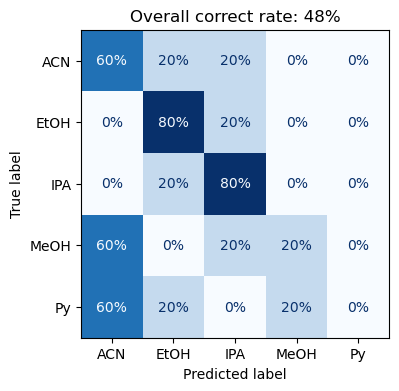

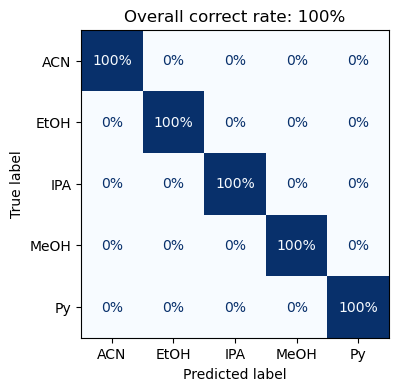

In [3]:
# assembly database
df_database_FTIR, H_database_FTIR = frs.interp_database_FTIR(freq_FRS, f_FTIR, abs_FTIR, df_FTIR)

#convert complex tranmission spectra to absorbance
h_frs = -np.log10(np.abs(hc_frs)**2)

# create objects containing the FRS and FTIR spectra using the SpectralData class
Data_FTIR =  SD.SpectralData(freq_FRS, H_database_FTIR, data_type='abs')
Data_FRS  =  SD.SpectralData(freq_FRS, h_frs, data_type='abs')
Data_FTIR.backup()
Data_FRS.backup()

# apply linear baselinecorrection
Data_FTIR.linblcorr(1000,1400)
Data_FRS.linblcorr(1000,1400)

# select spectral range for in which the database search is performed
f1, f2 =  1025, 1375
idx_f1, idx_f2   = (np.abs(freq_FRS  - f1)).argmin(), (np.abs(freq_FRS  - f2)).argmin() 
filter_FRS  = (df_FRS['conc'] == 0.01) #select concentration

# loop through all measurements and calculate the cosine similarity
y_true, y_pred = [],[]
j,k = 0,0
for i in df_FRS[filter_FRS].index:
    k += 1
    cosine_sim = frs.H_dbsearchsinglespecies(Data_FRS[i,idx_f1:idx_f2], Data_FTIR[:,idx_f1:idx_f2])
    res = 1 - cosine_sim
    y_true.append(df_FRS.loc[i,'substance'])
    y_pred.append(df_database_FTIR['substance'][res.argmin()])
    
    if df_FRS.loc[i,'substance'] == df_database_FTIR['substance'][res.argmin()]: j+=1

# plot the results using a confusion matrix
labels = ['ACN', 'EtOH', 'IPA', 'MeOH', 'Py']        
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
fig, ax = plt.subplots(figsize=(4,4))

disp.plot(cmap='Blues', values_format = '.0%', ax = ax, colorbar=False)
disp.ax_.set_title('Overall correct rate: {:.0%}'.format(j/k))


# perform the same search, however apply time-domain filtering to both, the FRS and FTIR data
Data_FTIR.loadbackup().tdf(900, w_f=SD.tukeyF(freq_FRS, f1, f2, 100))
Data_FRS.loadbackup().tdf(900, w_f=SD.tukeyF(freq_FRS, f1, f2, 100))

# loop through all measurements and calculate the cosine similarity
y_true, y_pred = [],[]
j,k = 0,0
for i in df_FRS[filter_FRS].index:
    k += 1
    cosine_sim = frs.H_dbsearchsinglespecies(Data_FRS[i,idx_f1:idx_f2], Data_FTIR[:,idx_f1:idx_f2])
    res = 1 - cosine_sim
    y_true.append(df_FRS.loc[i,'substance'])
    y_pred.append(df_database_FTIR['substance'][res.argmin()])
    
    if df_FRS.loc[i,'substance'] == df_database_FTIR['substance'][res.argmin()]: j+=1

# plot the results using a confusion matrix
labels = ['ACN', 'EtOH', 'IPA', 'MeOH', 'Py']        
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
fig, ax = plt.subplots(figsize=(4,4))

disp.plot(cmap='Blues', values_format = '.0%', ax = ax, colorbar=False)
disp.ax_.set_title('Overall correct rate: {:.0%}'.format(j/k))